In [1]:
import pandas as pd
import shap
import numpy as np
import pickle

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import IsolationForest

In [35]:
data = pd.read_parquet('20221007_CC_AD_DATA.parquet', engine='fastparquet')
len(data)

579989

describe and visualize data

         a1_curr_act    a2_curr_act    a3_curr_act    a4_curr_act  \
count  579989.000000  579989.000000  579989.000000  579989.000000   
mean        0.140691       0.396254      -0.325356      -0.110634   
std         1.970987       1.304368       1.159116       1.684823   
min       -38.457120     -17.689250     -62.524630     -62.544710   
25%        -0.029017       0.039265      -0.375184      -0.373921   
50%        -0.019487       0.072221      -0.338790       0.302395   
75%         0.193635       0.143750      -0.092842       0.392763   
max        40.614080      75.961560      70.755100      44.209050   

         a5_curr_act  a6_curr_act   a1_fol_error   a2_fol_error  \
count  579989.000000     579989.0  579989.000000  579989.000000   
mean       -0.009901          0.0      -0.000242       0.000076   
std         2.297570          0.0       0.107112       0.106951   
min       -45.797680          0.0      -1.686261      -1.554926   
25%        -0.567184          0.0       0.0

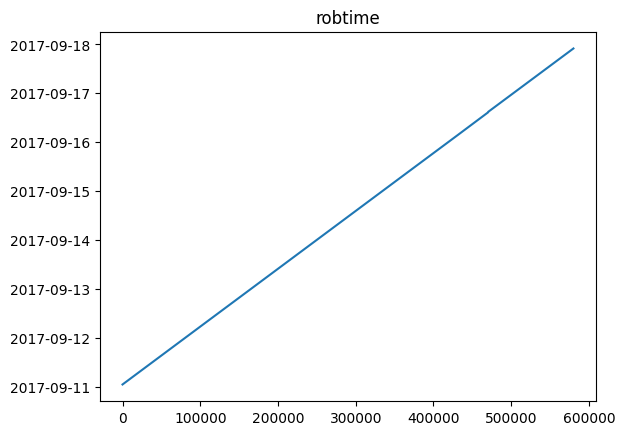

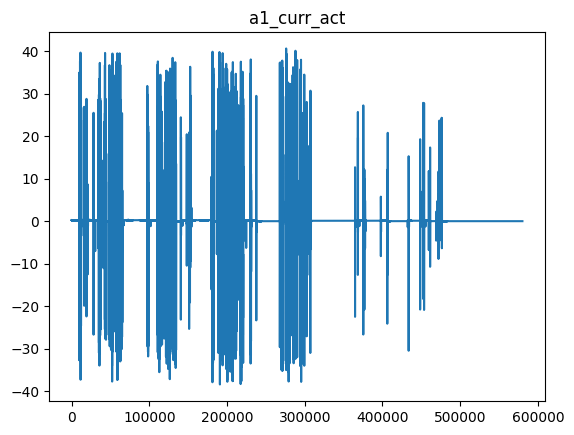

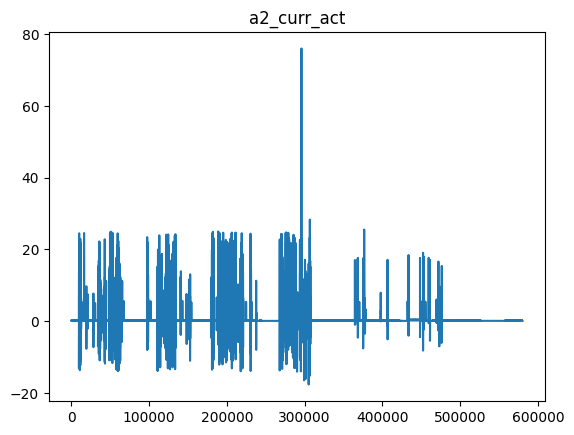

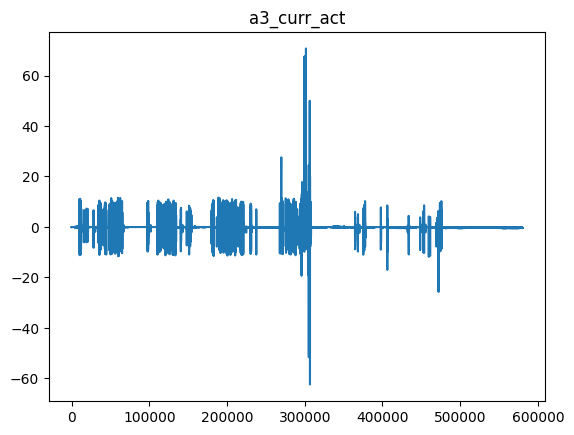

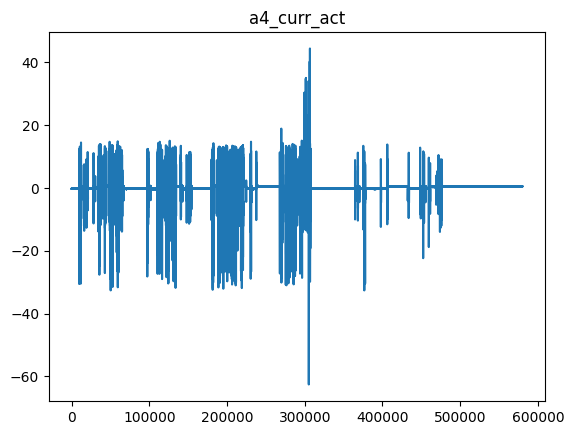

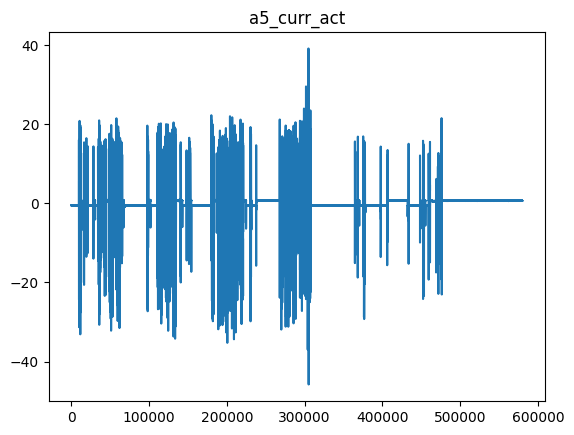

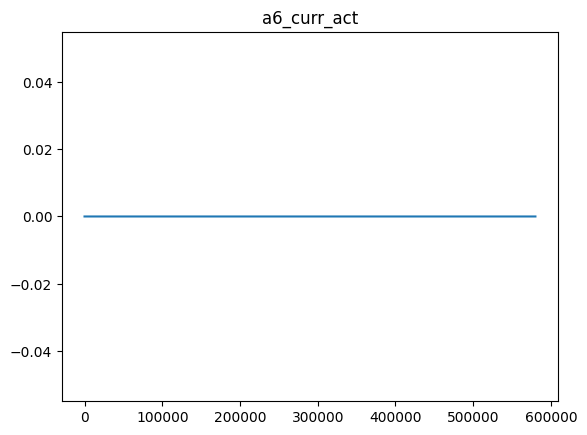

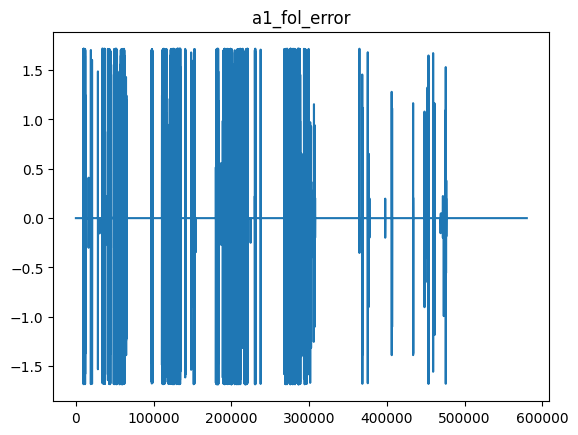

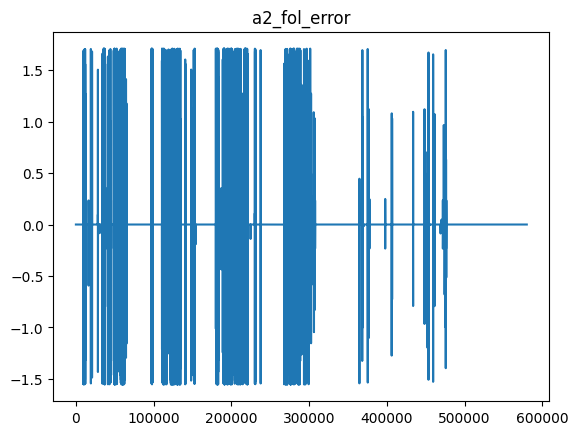

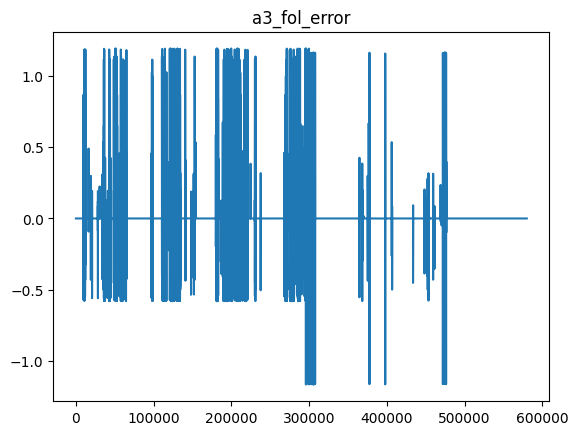

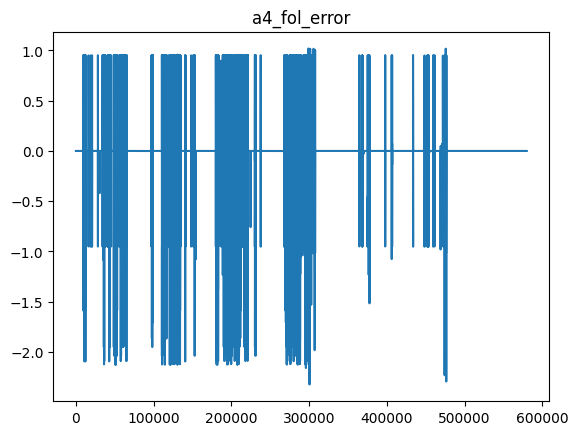

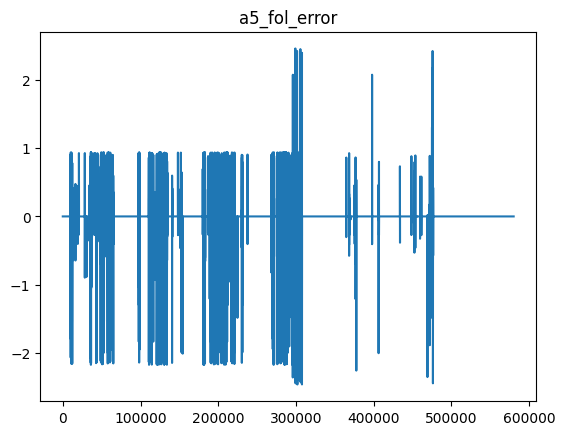

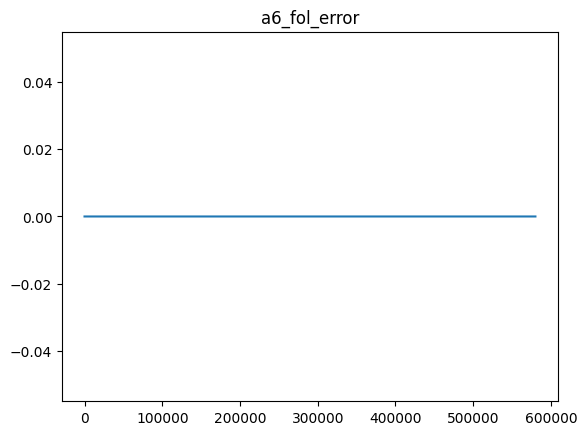

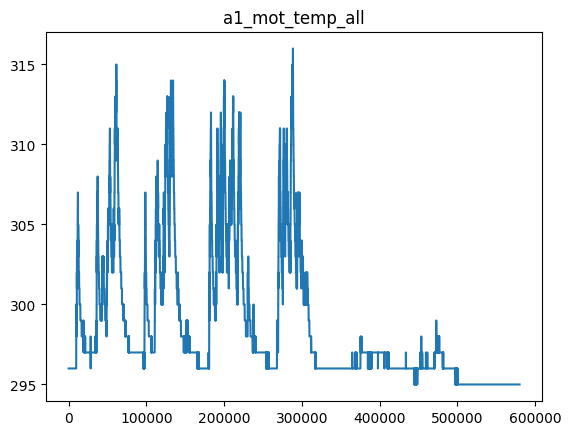

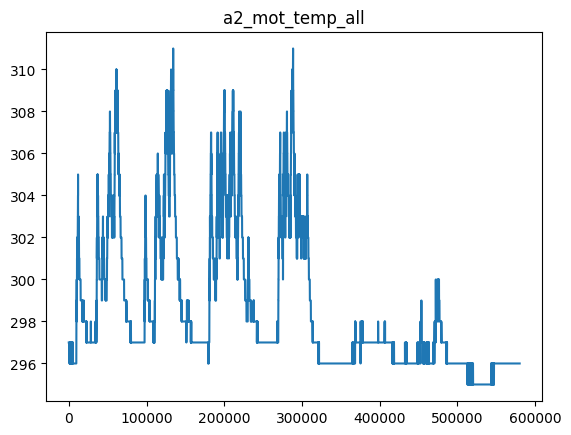

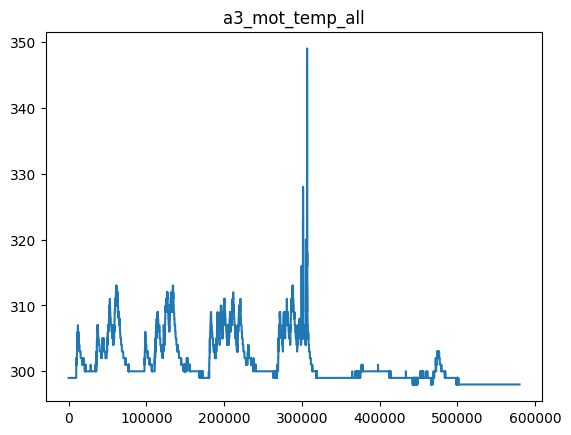

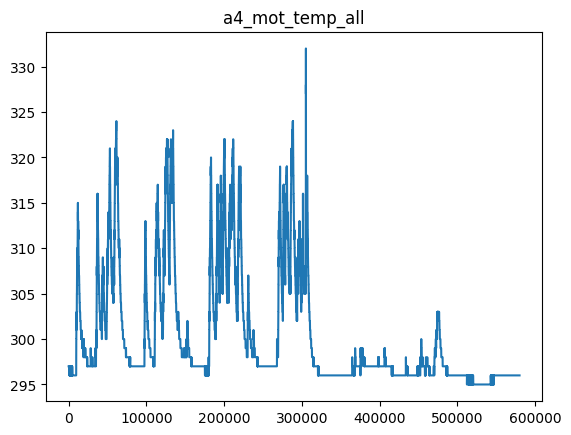

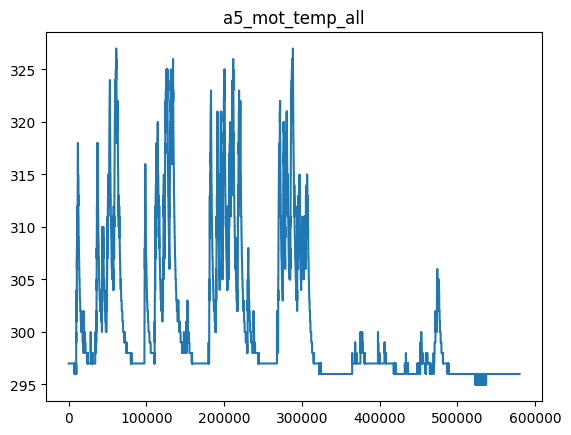

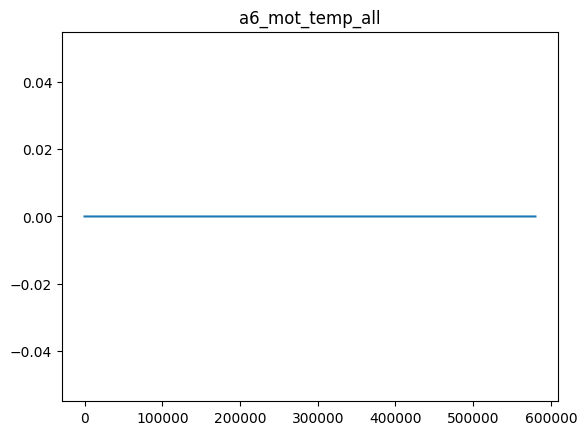

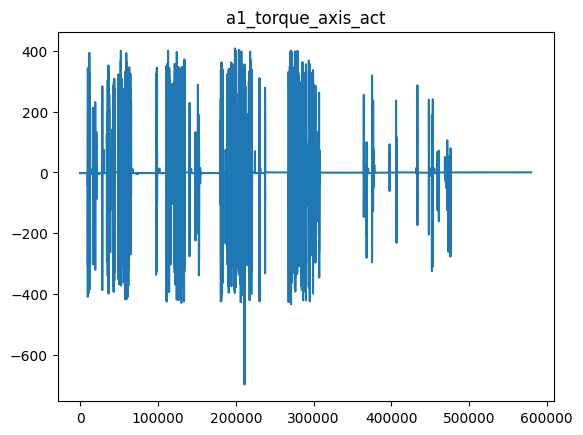

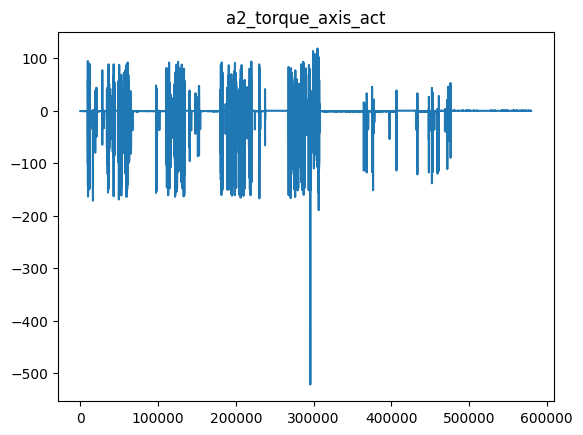

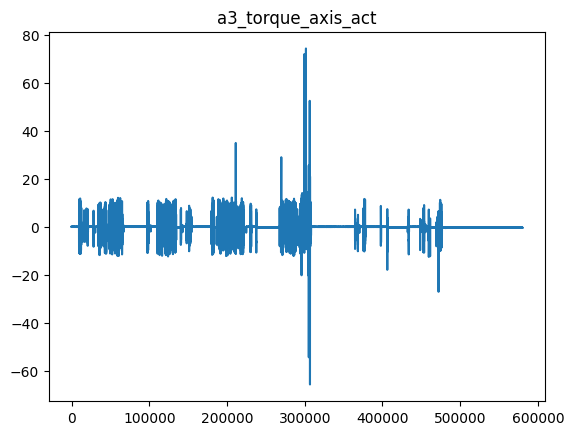

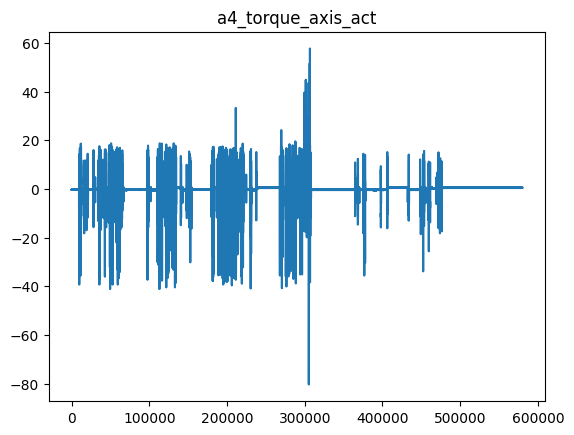

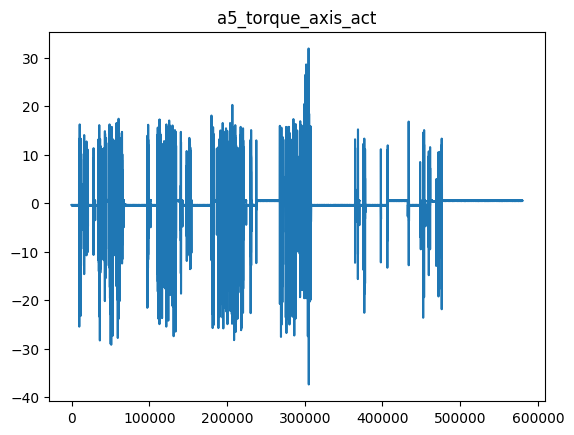

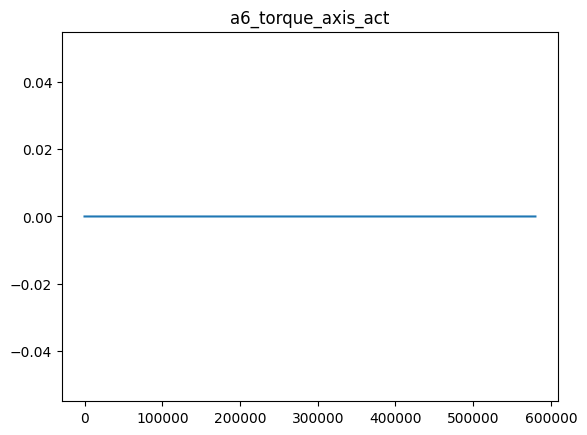

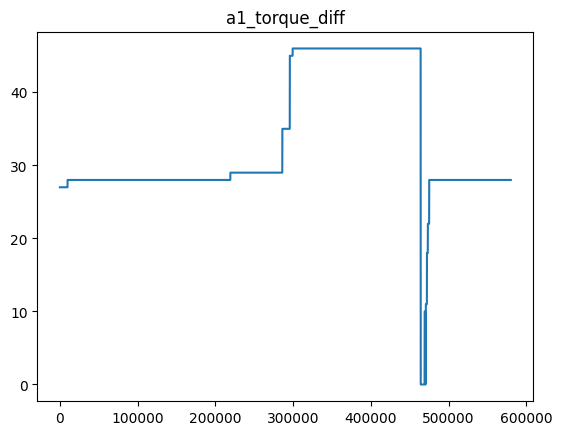

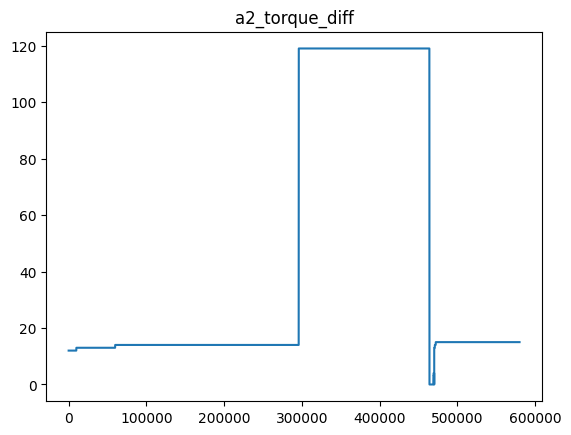

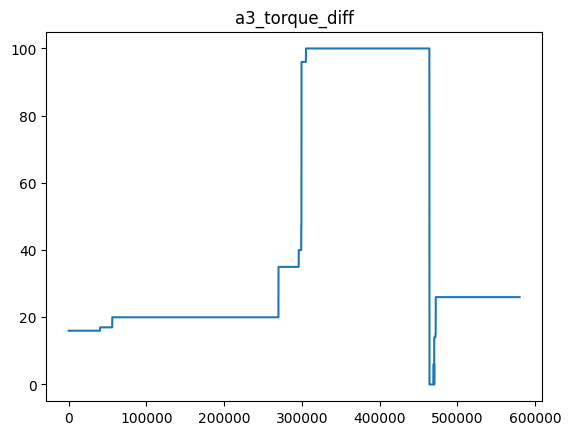

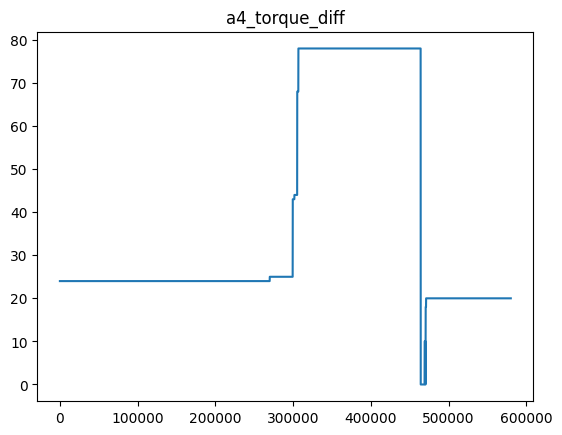

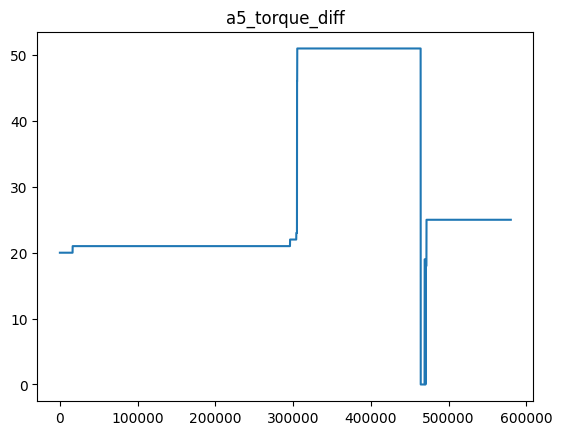

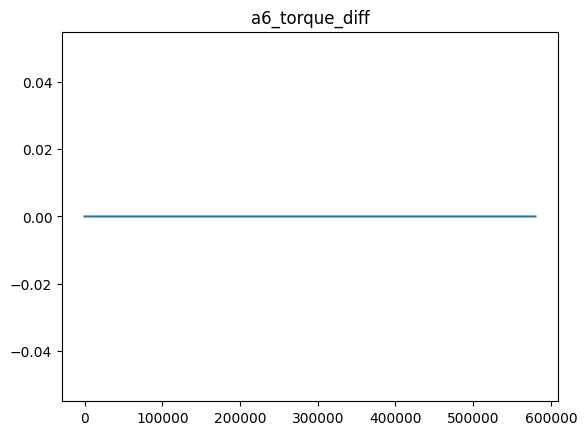

In [3]:
print(data.describe())
# plot each column as time series
for col in data.columns:
    plt.plot(data[col])
    plt.title(col)
    plt.show()

remove a6 as it contains no valuable information.
after train test split remove robtime also

In [43]:
# remove a6
data = data.drop([col for col in data.columns if col.startswith('a6')], axis=1)
print(len(data.columns))
print(data.columns)

26
Index(['robtime', 'a1_curr_act', 'a2_curr_act', 'a3_curr_act', 'a4_curr_act',
       'a5_curr_act', 'a1_fol_error', 'a2_fol_error', 'a3_fol_error',
       'a4_fol_error', 'a5_fol_error', 'a1_mot_temp_all', 'a2_mot_temp_all',
       'a3_mot_temp_all', 'a4_mot_temp_all', 'a5_mot_temp_all',
       'a1_torque_axis_act', 'a2_torque_axis_act', 'a3_torque_axis_act',
       'a4_torque_axis_act', 'a5_torque_axis_act', 'a1_torque_diff',
       'a2_torque_diff', 'a3_torque_diff', 'a4_torque_diff', 'a5_torque_diff'],
      dtype='object')


In [44]:
# train test split: 2017-09-11 are training data, the rest are testing data
train = data[data.loc[:,'robtime'] < '2017-09-12']
test = data[data.loc[:,'robtime'] > '2017-09-12']
print(len(train),len(test), (len(data)))

80917 499072 579989


In [45]:
# drop column robtime as not useful for anomaly detection
train = train.drop(['robtime'], axis=1)
test = test.drop(['robtime'], axis=1)

# isolation forest

In [46]:
# anomaly detection with isolation forest (scikit-learn)
# when a forest of random trees collectively produce shorter path lengths for particular samples,
# they are highly likely to be anomalies.

# train
clf1 = IsolationForest(random_state=0).fit(train)
print(clf1)

IsolationForest(random_state=0)


In [47]:
pred = clf1.predict(test)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [48]:
# calculate the Anomaly Score.
# A positive score shows a normal point, whereas a negative score represents an Anomalous point.
isofor_score = clf1.decision_function(test)
isofor_score

array([0.11155147, 0.09850253, 0.11242766, ..., 0.04325544, 0.04171881,
       0.03981649])

In [49]:
# find the points that have been predicted/marked as anomalous
neg_value_indices = np.where(isofor_score<0)
frac_anomalies_isolation_forst = len(neg_value_indices[0])/len(test)
print('n anomalies:', len(neg_value_indices[0]), '\nfrac_anomalies_isolation_forst:', frac_anomalies_isolation_forst)

n anomalies: 43542 
frac_anomalies_isolation_forst: 0.08724592844319057


In [50]:
# Tree Explainer
# create an explainer object
explainer = shap.TreeExplainer(clf1, data=train)
explainer

In [12]:
# calculate shap values
shapvs = explainer.shap_values(train, check_additivity=False)  # check should be default
shapvs

100%|===================| 80765/80917 [05:27<00:00]        

array([[ 0.13740303,  0.16500572,  0.06124622, ...,  0.15978558,
         0.        , -0.79171939],
       [ 0.09905575,  0.18720402,  0.07947568, ...,  0.1613334 ,
         0.        , -0.75809332],
       [ 0.07553344,  0.15373636,  0.04405288, ...,  0.15078482,
         0.        , -0.81484471],
       ...,
       [ 0.12606147,  0.09557082,  0.0205518 , ..., -0.52391156,
         0.        ,  0.19798926],
       [ 0.09641726,  0.12262298,  0.05822502, ..., -0.61317774,
         0.        ,  0.17621402],
       [ 0.13034778,  0.12270684,  0.0507463 , ..., -0.51873835,
         0.        ,  0.18767147]])

In [ ]:
frac_anomalies_isolation_forst

In [13]:
# save shapvs to file via pickle to save time
with open('shapvs.pickle', 'wb') as f:
    pickle.dump(shapvs, f)

In [51]:
# load
with open('shapvs.pickle', 'rb') as f:
    shapvs = pickle.load(f)
shapvs

array([[ 0.13740303,  0.16500572,  0.06124622, ...,  0.15978558,
         0.        , -0.79171939],
       [ 0.09905575,  0.18720402,  0.07947568, ...,  0.1613334 ,
         0.        , -0.75809332],
       [ 0.07553344,  0.15373636,  0.04405288, ...,  0.15078482,
         0.        , -0.81484471],
       ...,
       [ 0.12606147,  0.09557082,  0.0205518 , ..., -0.52391156,
         0.        ,  0.19798926],
       [ 0.09641726,  0.12262298,  0.05822502, ..., -0.61317774,
         0.        ,  0.17621402],
       [ 0.13034778,  0.12270684,  0.0507463 , ..., -0.51873835,
         0.        ,  0.18767147]])

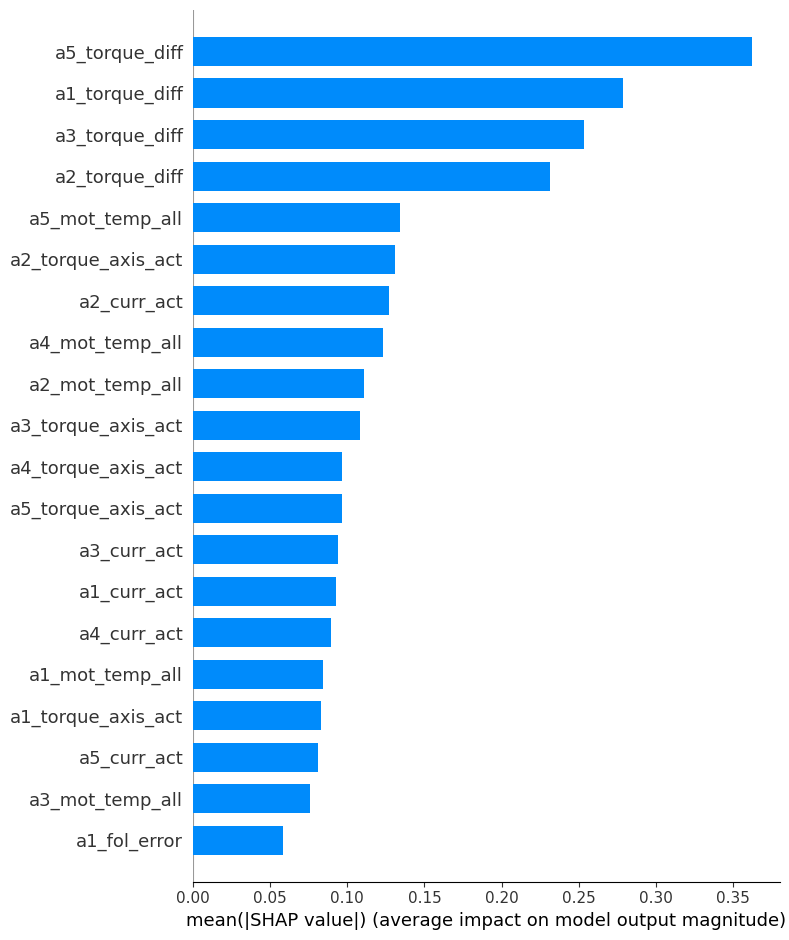

In [15]:
# visualize the global importance of features
# blue bar shows importance
# blue dots: low values
# red dots high values
# low SHAP values (left) -> anomaly
# high SHAP values (right) -> nominal
shap.summary_plot(shapvs, train, plot_type="bar", color_bar=True)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

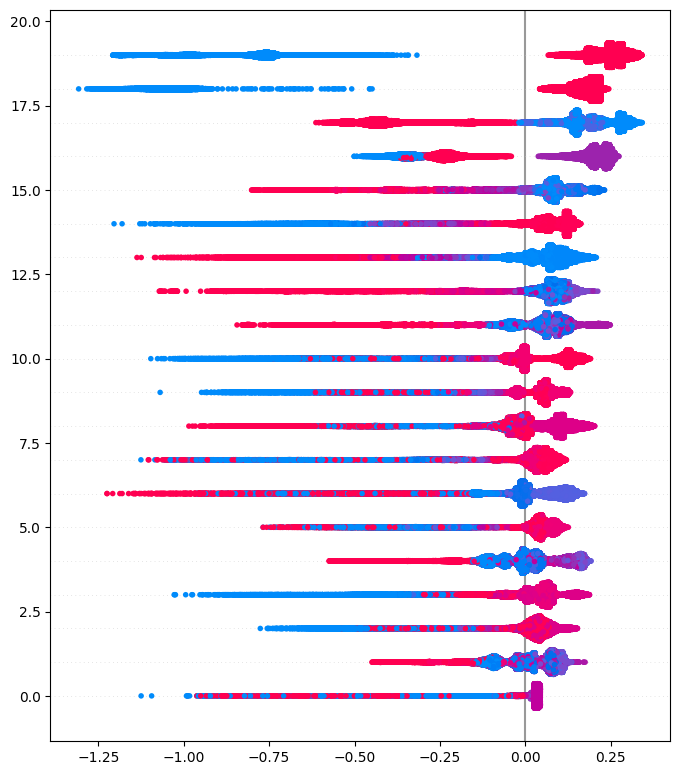

In [17]:
shap.summary_plot(shapvs, train, color_bar=True,feature_names=train.columns)


In [52]:
# explanation for particaular point
# shows the influence of feature(s) on the predictions
idx = 1041
shap.force_plot(explainer.expected_value, shapvs[idx],features =train.iloc[idx,:] ,feature_names =test.columns)


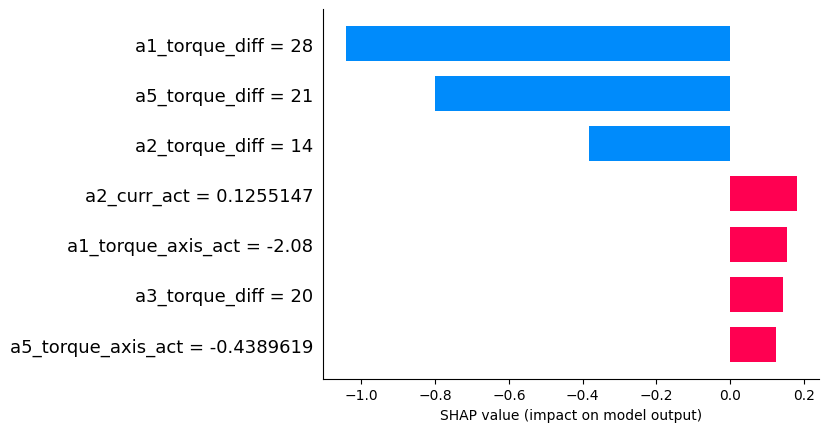

In [53]:
shap.bar_plot(shapvs[idx],features =test.iloc[idx,:] ,feature_names =test.columns )


a1, a2, a3 torque diff are pushing the outcome towards being an anomaly.
# autoencoder

In [54]:
import tensorflow as tf
from keras import layers, losses
from keras.models import Model


In [55]:
# normalize data
train_norm = (train - train.mean()) / train.std()
test_norm = (test - test.mean()) / test.std()

        a1_curr_act   a2_curr_act   a3_curr_act   a4_curr_act   a5_curr_act  \
count  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04   
mean  -1.159109e-17 -5.057931e-17  1.404981e-17 -1.756226e-17  2.809962e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.564684e+01 -9.505910e+00 -8.666886e+00 -1.591229e+01 -1.204042e+01   
25%   -1.098154e-01 -3.368091e-01 -1.580410e-02 -2.789929e-02 -1.279826e-01   
50%   -1.952396e-02 -2.783937e-01  1.804720e-01 -1.679403e-02 -1.178795e-01   
75%   -1.269770e-02 -2.687285e-01  1.958464e-01  3.386917e-01  3.206935e-01   
max    1.622108e+01  1.595097e+01  9.117269e+00  7.388127e+00  7.938711e+00   

       a1_fol_error  a2_fol_error  a3_fol_error  a4_fol_error  a5_fol_error  \
count  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04  8.091700e+04   
mean   7.903017e-18  6.629754e-18 -1.756226e-19  5.795546e-18  1.789155e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

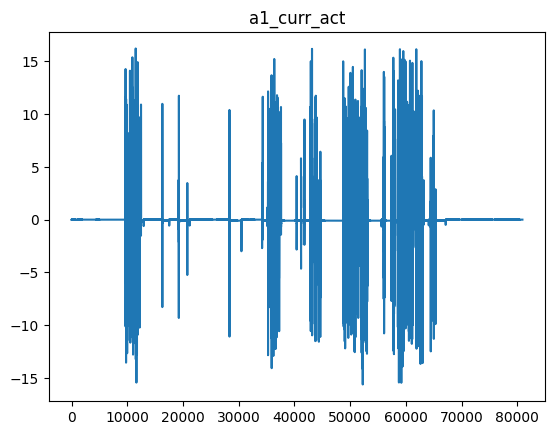

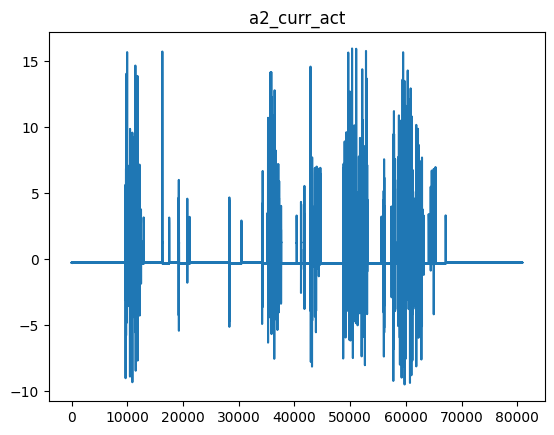

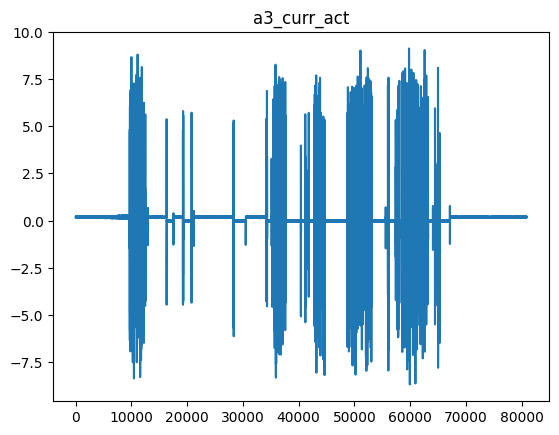

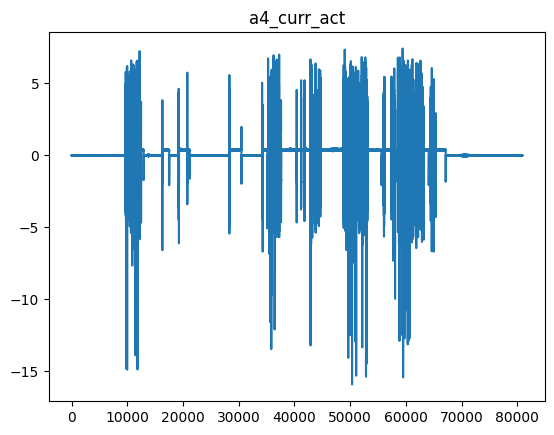

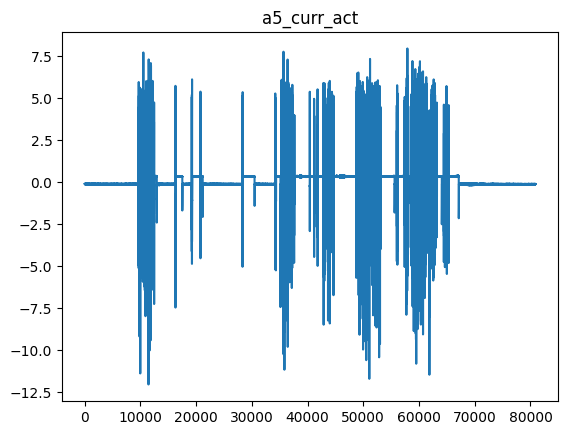

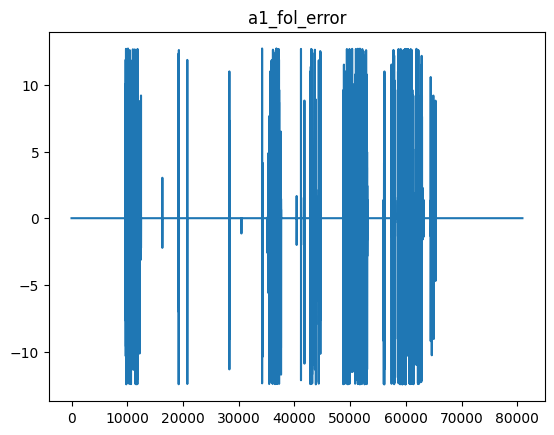

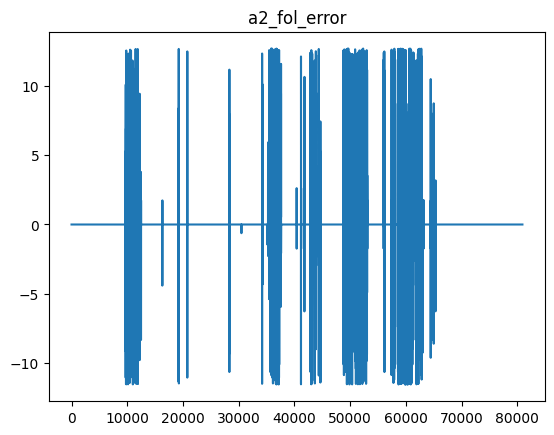

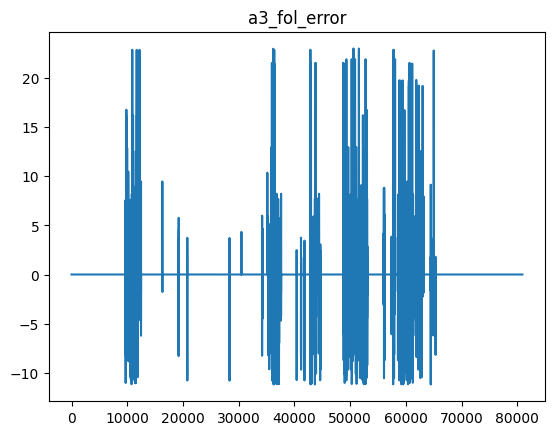

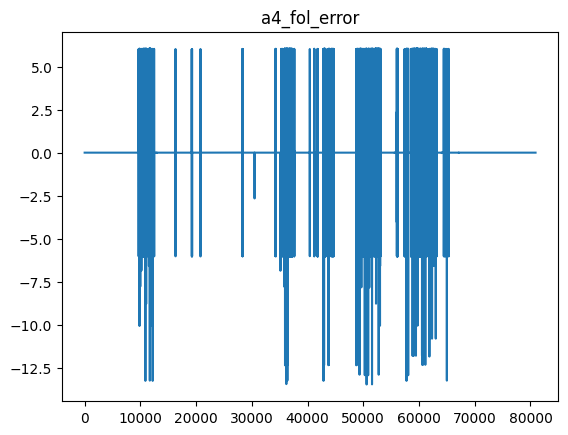

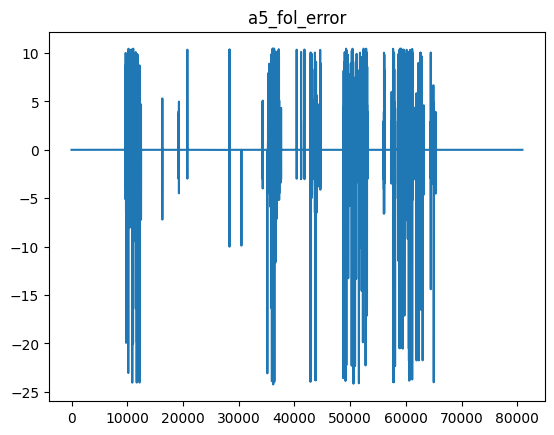

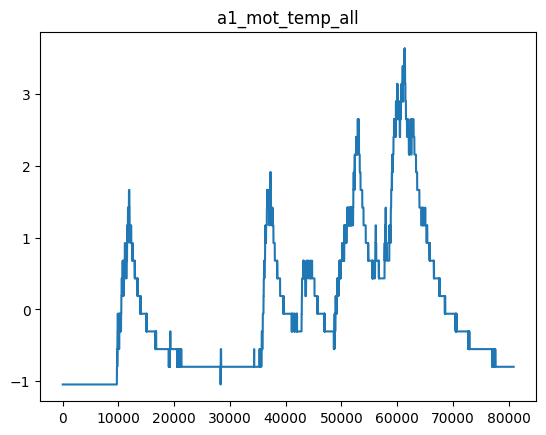

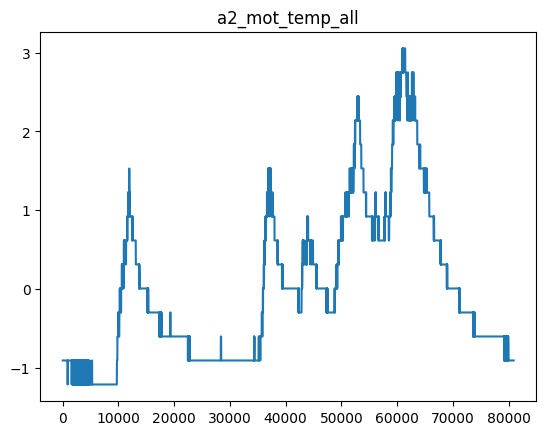

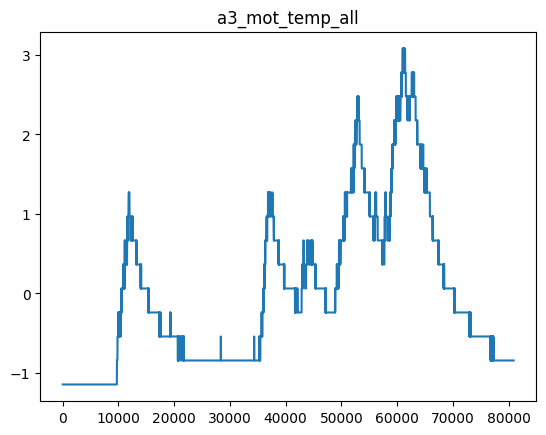

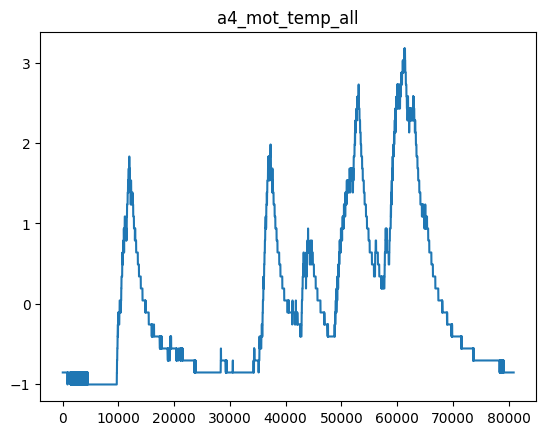

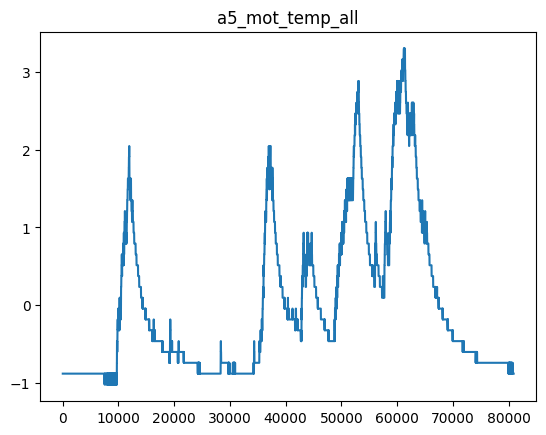

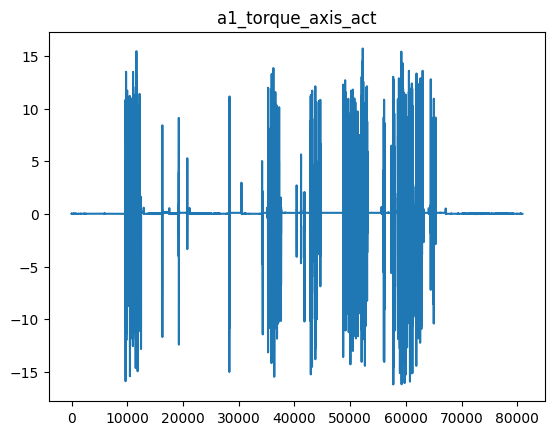

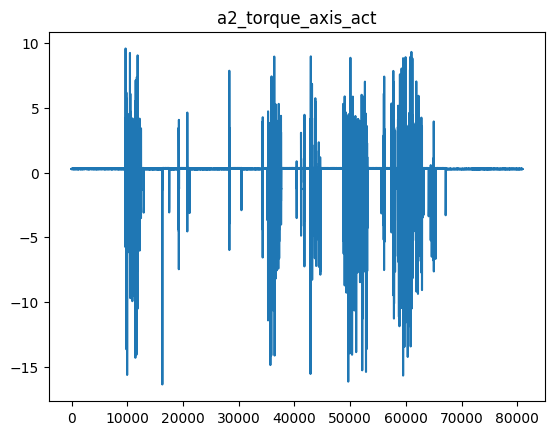

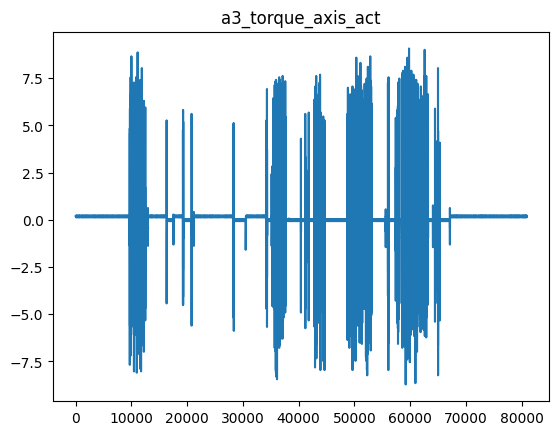

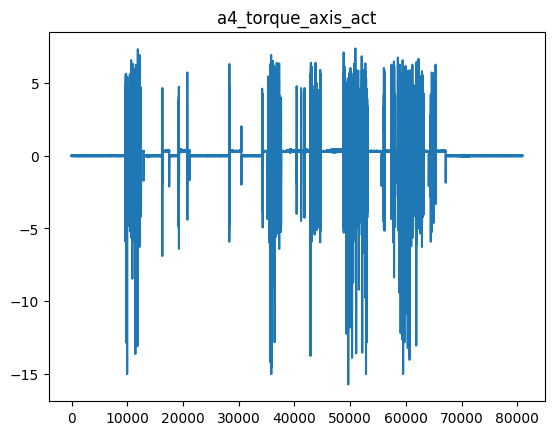

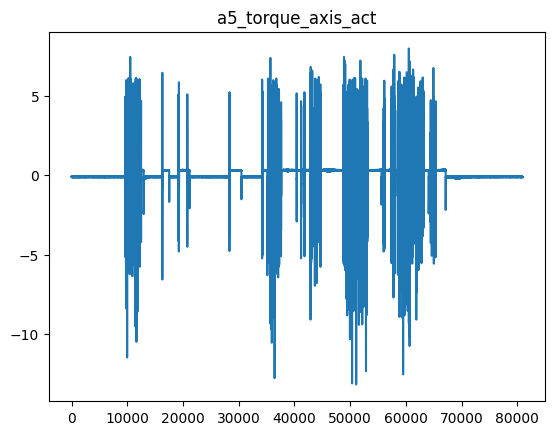

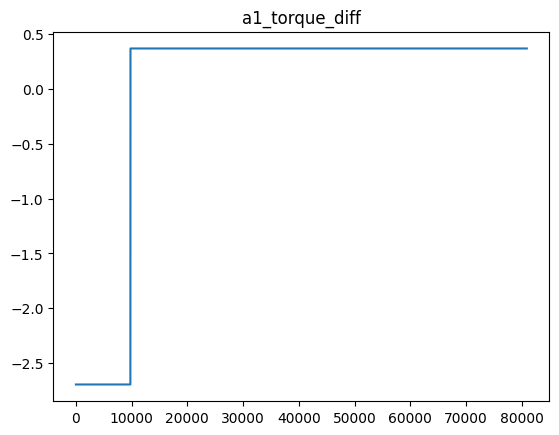

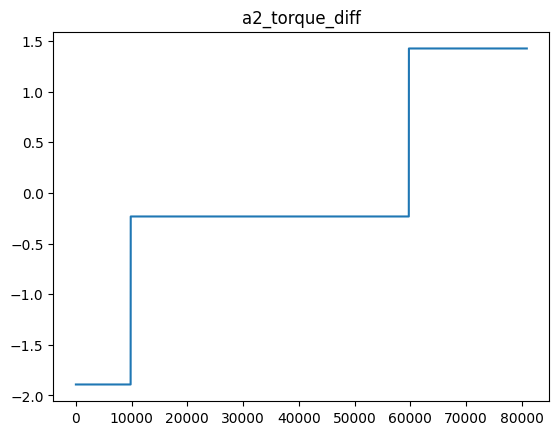

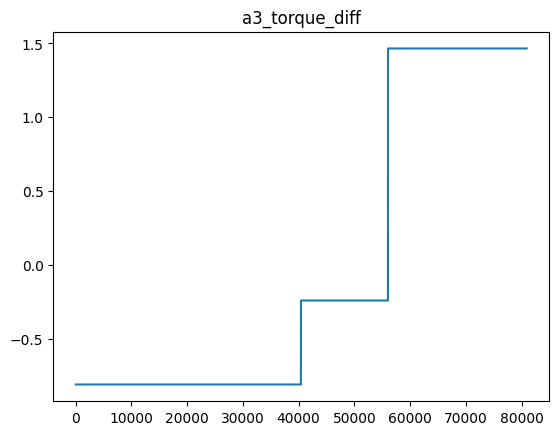

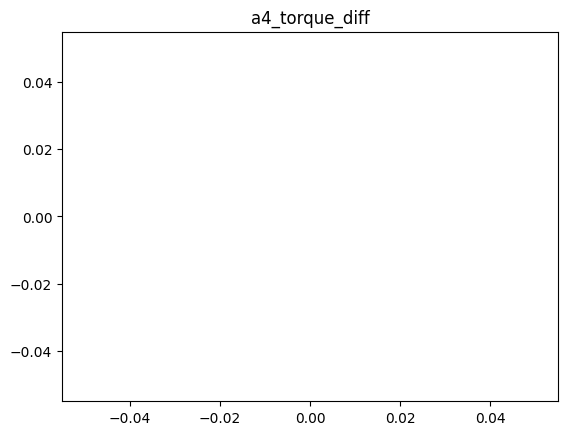

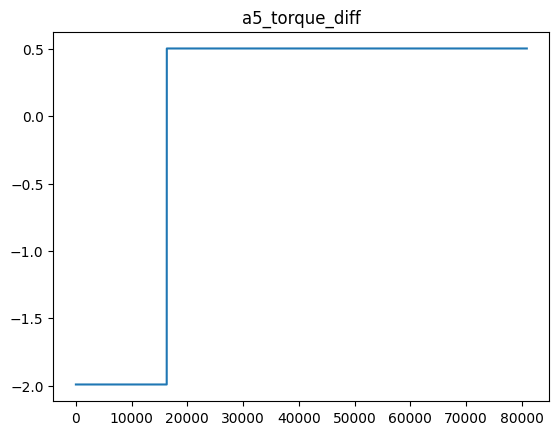

In [57]:
# check if normalization went as expected
print(train_norm.describe())
for col in train_norm.columns:
    plt.plot(train_norm[col])
    plt.title(col)
    plt.show()

In [58]:
# drop a4_torque_diff
test_norm = test_norm.drop(['a4_torque_diff'], axis=1)
train_norm = train_norm.drop(['a4_torque_diff'], axis=1)

In [59]:
# Build the model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(1, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(24, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(train_norm, train_norm,
          epochs=20,
          batch_size=512,
          validation_data=(test_norm, test_norm),
          shuffle=True)

Epoch 1/40
159/159 [==============================] - 1s 8ms/step - loss: 0.7055 - val_loss: 0.6759
Epoch 2/40
159/159 [==============================] - 1s 5ms/step - loss: 0.5599 - val_loss: 0.5326
Epoch 3/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4816 - val_loss: 0.5096
Epoch 4/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4723 - val_loss: 0.5051
Epoch 5/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4664 - val_loss: 0.5005
Epoch 6/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4618 - val_loss: 0.4973
Epoch 7/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4583 - val_loss: 0.4954
Epoch 8/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4553 - val_loss: 0.4958
Epoch 9/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4529 - val_loss: 0.4954
Epoch 10/40
159/159 [==============================] - 1s 5ms/step - loss: 0.4503 - val_loss: 0.4958

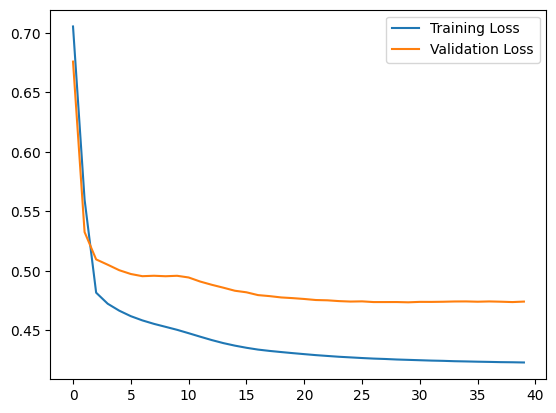

In [60]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

anomalous if the reconstruction error is greater than one standard deviation from the normal training examples.
plot normal from the training set,
the reconstruction after it's encoded and decoded by the autoencoder,
and the reconstruction error.

### setting the threshold
depends on:
* ground truth available? -> optimization to minimize loss
    + here, I assume isolation forest are the ground truth and adapt the autoencoder threshold
* do we know the ratio of anomalies?
* Are false positives / false negatives equally bad?
    + e.g. smoke detectors false negaitves are worse than false positives.
* one can look at the distribution and see if there are outliers (red lines above)



2529/2529 [==============================] - 1s 556us/step


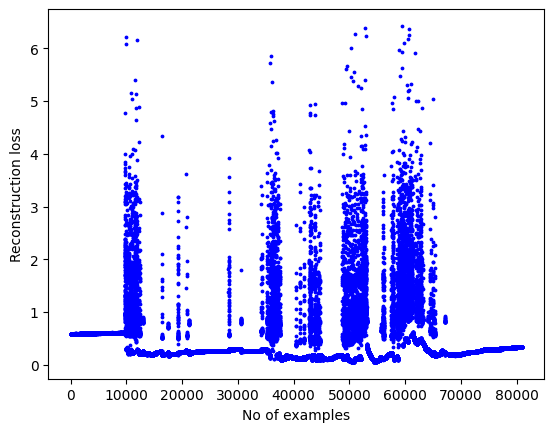

In [61]:
reconstructions_train = autoencoder.predict(train_norm)
train_loss = tf.keras.losses.mae(reconstructions_train, train_norm)

# plot loss
plt.scatter(range(len(train_loss)), train_loss, c='b', s=3, label='train loss')
plt.xlabel("No of examples")
plt.ylabel("Reconstruction loss")
plt.show()


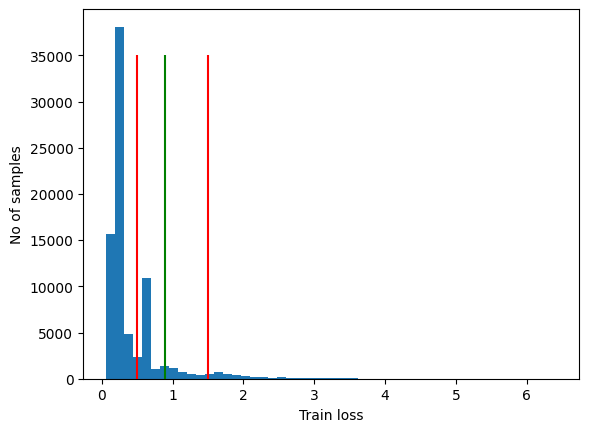

In [62]:
# get threshold so fraction between iso forest and autoencoder is the same
threshold_autoencoder = np.percentile(train_loss[None,:], (1-frac_anomalies_isolation_forst)*100)

plt.hist(train_loss[None,:], bins=50)
plt.vlines(1.5, ymin=0, ymax=35000, colors="r", zorder=100, label='Threshold1')
plt.vlines(0.5, ymin=0, ymax=35000, colors="r", zorder=100, label='Threshold2')
plt.vlines(threshold_autoencoder, ymin=0, ymax=35000, colors="g", zorder=100, label='threshold_autoencoder')
plt.xlabel("Train loss")
plt.ylabel("No of samples")
plt.show()

## predict on test set

In [66]:
reconstructions_test = autoencoder.predict(test_norm)
loss_test = tf.keras.losses.mae(reconstructions_test, test_norm)
prediction_autoencoder_test = tf.math.greater(loss_test, threshold_autoencoder)
# print number of true in prediction
print(prediction_autoencoder_test.numpy().sum())
print('frac of anomalies in test data: {}'.format(prediction_autoencoder_test.numpy().sum()/len(test)))

15596/15596 [==============================] - 10s 615us/step
38824
frac of anomalies in test data: 0.07779238266222108


In [64]:
# compare isolation forest with autoencoder
# create new variable prediction_isolationforest with True for anomalies and False for normal
prediction_isolationforest = []
for i in isofor_score:
    if i <0:
        prediction_isolationforest.append(1)
    else:
        prediction_isolationforest.append(0)
print(len(prediction_isolationforest))

499072


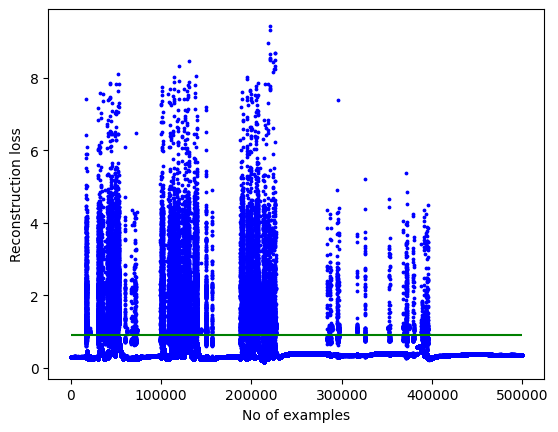

In [68]:
# plot test loss
plt.scatter(range(len(loss_test)), loss_test, c='b', s=3, label='Test loss')
plt.xlabel("No of examples")
plt.ylabel("Reconstruction loss")
plt.hlines(threshold_autoencoder, xmin=0, xmax=len(loss_test), colors="g", zorder=100, label='threshold_autoencoder')
plt.show()

n differences:  7634 frac diff: 0.015296390100025647


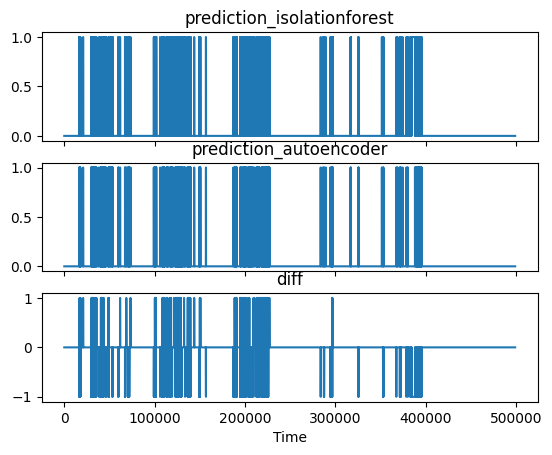

In [69]:
# plot isofor_score_binary and prediction as subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(prediction_isolationforest)
ax1.set_title('prediction_isolationforest')
ax2.plot(prediction_autoencoder_test)
ax2.set_title('prediction_autoencoder')
diff = np.subtract(prediction_autoencoder_test.numpy(),np.array(prediction_isolationforest))
print('n differences: ', abs(diff).sum(), 'frac diff:', abs(diff).sum()/len(prediction_isolationforest))
ax3.plot(diff)
ax3.set_title('diff')

plt.xlabel("Time")
plt.show()

at a first clance the results look similar